# Sendy Logistics Challenge

This is a machine learning model to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination for a logistics company.

The solution will help Sendy enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience. In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling.

## Import the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import pickle

### Import the Datasets

In [2]:
test = pd.read_csv('https://raw.githubusercontent.com/mhloti/Working-with-Datasets/master/Data/Test.csv')
train = pd.read_csv('https://raw.githubusercontent.com/mhloti/Working-with-Datasets/master/Data/Train.csv')
riders = pd.read_csv('https://raw.githubusercontent.com/mhloti/Working-with-Datasets/master/Data/Riders.csv')

In [3]:
# join the test dataset with the riders dataset
new_test = test.merge(riders, on = 'Rider Id', how = 'inner')
new_test.head(2)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171
1,Order_No_2699,User_Id_592,Bike,1,Personal,26,2,2:43:21 PM,26,2,...,NaN,-1.312745,36.875715,-1.288435,36.760677,Rider_Id_192,439,1511,13.3,171


In [4]:
# join the train dataset with the riders dataset
new_train = train.merge(riders, on = 'Rider Id', how = 'inner')
new_train.head(2)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_27440,User_Id_2642,Bike,3,Personal,18,5,3:41:17 PM,18,5,...,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549


## Exploratory Data Analysis

In [5]:
# shape of the test data
new_test.shape

(7068, 29)

In [6]:
# info on the test data
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 33 columns):
Order No                                     21201 non-null object
User Id                                      21201 non-null object
Vehicle Type                                 21201 non-null object
Platform Type                                21201 non-null int64
Personal or Business                         21201 non-null object
Placement - Day of Month                     21201 non-null int64
Placement - Weekday (Mo = 1)                 21201 non-null int64
Placement - Time                             21201 non-null object
Confirmation - Day of Month                  21201 non-null int64
Confirmation - Weekday (Mo = 1)              21201 non-null int64
Confirmation - Time                          21201 non-null object
Arrival at Pickup - Day of Month             21201 non-null int64
Arrival at Pickup - Weekday (Mo = 1)         21201 non-null int64
Arrival at Pickup - Time   

### Convert Time into Seconds

In [7]:
# convert time into seconds

time = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time', 
        'Arrival at Destination - Time']

for t in time:
    new_train[t] = [int(v.split(':')[0]) * 3600 + int(v.split(':')[1]) * 60 + int(v.split(':')[2][:2]) \
                for i, v in new_train[t].items()]

for t in ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']:
    new_test[t] = [int(v.split(':')[0]) * 3600 + int(v.split(':')[1]) * 60 + int(v.split(':')[2][:2]) \
                for i, v in new_test[t].items()]

### Summary Statistics

In [8]:
# summary statistics of the train data
new_train.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,...,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,...,552.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,2.752182,15.653696,3.240083,26075.234800,15.653837,3.240225,25823.818971,15.653837,3.240225,25428.697561,...,7.905797,-1.281470,36.811264,-1.282581,36.811220,1556.920947,1692.423706,984.742842,13.882520,341.067119
std,0.625178,8.798916,1.567295,14710.524863,8.798886,1.567228,14703.064869,8.798886,1.567228,14725.837143,...,17.089971,0.030507,0.037473,0.034824,0.044721,987.270788,1574.308302,646.652835,0.916071,402.867746
min,1.000000,1.000000,1.000000,3601.000000,1.000000,1.000000,3600.000000,1.000000,1.000000,3603.000000,...,0.100000,-1.438302,36.653621,-1.430298,36.606594,1.000000,2.000000,96.000000,0.000000,0.000000
25%,3.000000,8.000000,2.000000,11167.000000,8.000000,2.000000,11227.000000,8.000000,2.000000,11227.000000,...,1.075000,-1.300921,36.784605,-1.301201,36.785661,882.000000,557.000000,495.000000,13.600000,61.000000
50%,3.000000,15.000000,3.000000,31542.000000,15.000000,3.000000,30839.000000,15.000000,3.000000,25336.000000,...,2.900000,-1.279395,36.807040,-1.284382,36.808002,1369.000000,1212.000000,872.000000,14.000000,161.000000
75%,3.000000,23.000000,5.000000,39768.000000,23.000000,5.000000,39718.000000,23.000000,5.000000,39690.000000,...,4.900000,-1.257147,36.829741,-1.261177,36.829477,2040.000000,2311.000000,1236.000000,14.300000,495.000000
max,4.000000,31.000000,7.000000,46799.000000,31.000000,7.000000,46798.000000,31.000000,7.000000,46798.000000,...,99.100000,-1.147170,36.991046,-1.030225,37.016779,7883.000000,9756.000000,3764.000000,15.200000,2298.000000


### Distribution Plot

It plots a univariate distribution of observations.

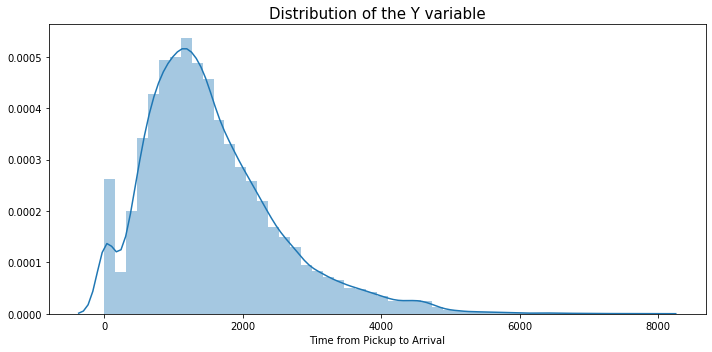

In [9]:
# distribution of the 'Time from Pickup to Arrival'

plt.figure(figsize = (10, 5))
sns.distplot(new_train['Time from Pickup to Arrival'])
plt.xlabel('Time from Pickup to Arrival')
plt.title('Distribution of the Y variable', {'fontsize': 15}, loc = 'center')

plt.tight_layout()
plt.show()

### Heatmap

A representation of data that uses a system of color-coding to represent different values.

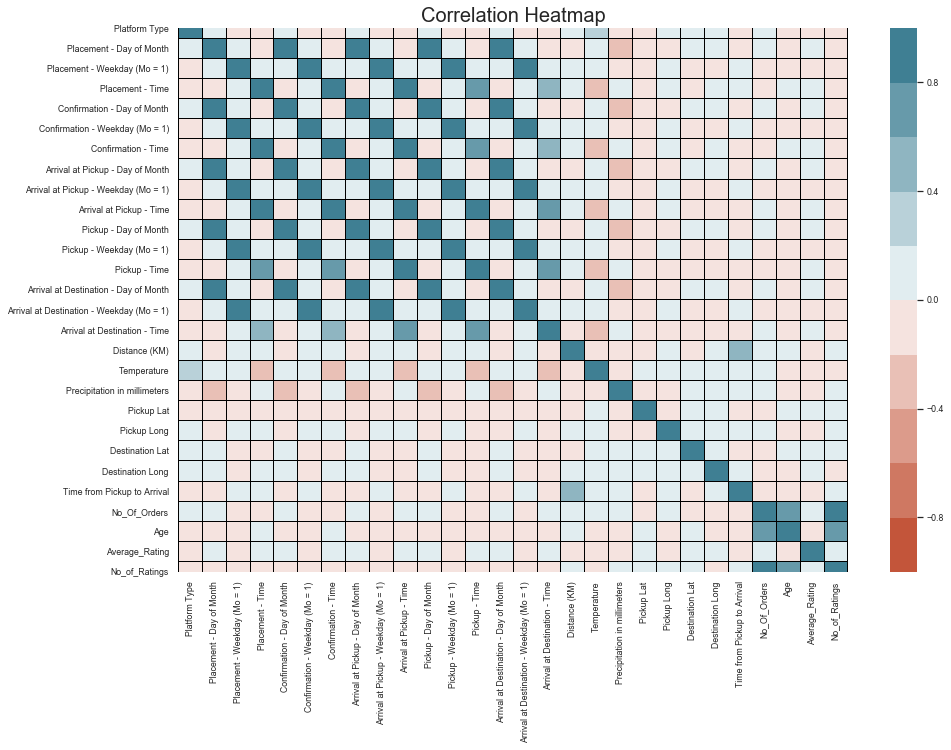

In [10]:
# correlation heatmap of the variables of the train data
corr = new_train.corr()

plt.figure(figsize = [15, 10])
sns.set(font_scale = 0.8)
cmap = sns.diverging_palette(20, 220, n = 10)
sns.heatmap(corr, vmin=-1, vmax=1, cmap=cmap, linewidths=0.02, linecolor='black')
plt.title('Correlation Heatmap', {'fontsize': 20}, loc = 'center')
plt.show()

### Pair Plot

A pairwise relationships in a dataset

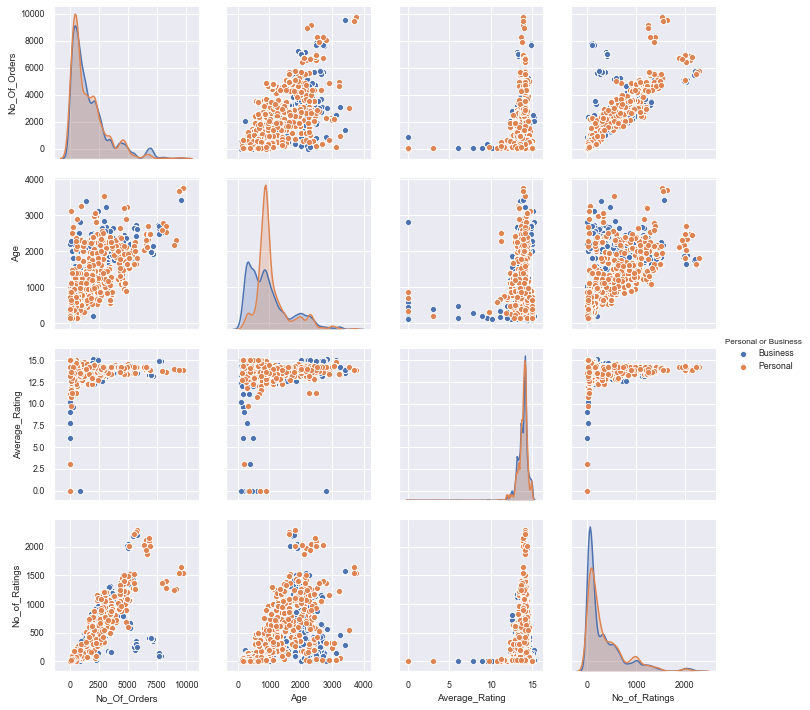

In [11]:
# a pairplot of the riders data with the 'Business or Personal' column

sns.pairplot(new_train.loc[:,['No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings', 'Personal or Business']],
             hue = 'Personal or Business')
plt.show()

### Strip Plot

A scatter plot where one of the variables is categorical.

In [12]:
# set bins for the 'Age' column
experience = pd.qcut(new_train['Age'], 4, labels=["Entry-level", "Intermediate", "Mid-level", "Senior"])
new_train['Experience'], new_test['Experience'] = experience, experience

# convert time variables into 'AM' and 'PM'
new = train.copy().merge(riders, on = 'Rider Id', how = 'inner')
for t in time:
    new[t] = [0 if v.split(':')[2][-2:] == 'AM' else 1 for i, v in new[t].items()]
    time_bins = pd.cut(new[t], 2, labels=["AM", "PM"])
    new[t] = time_bins

# add experince to the new dataframe
new['Experience'] = experience

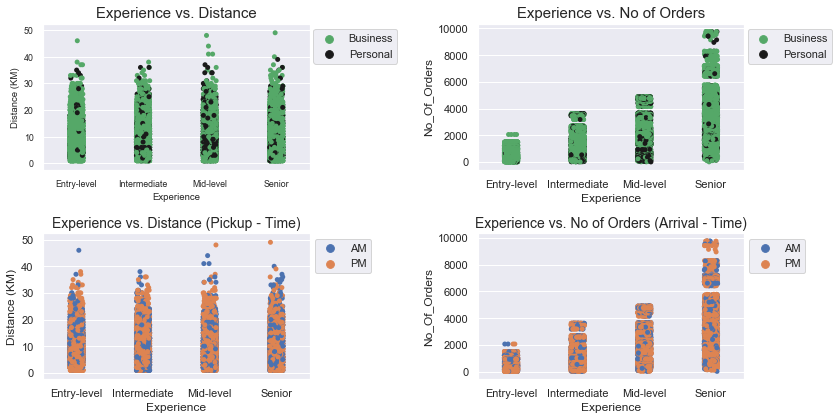

In [13]:
plt.figure(figsize = (12, 6))

# plot 1
plt.subplot(2, 2, 1)
sns.set(font_scale = 1)
sns.stripplot(x = 'Experience', y = 'Distance (KM)', data = new_train, orient = 'v', hue = 'Personal or Business',
              jitter = True, palette = ["C12", "k"])
plt.title('Experience vs. Distance', {'fontsize': 15}, loc = 'center')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1), ncol=1)

# plot 2
plt.subplot(2, 2, 2)
sns.set(font_scale = 1)
sns.stripplot(x = 'Experience', y = 'No_Of_Orders', data = new_train, orient = 'v', hue = 'Personal or Business',
             jitter = True, palette = ["C12", "k"])
plt.title('Experience vs. No of Orders', {'fontsize': 15}, loc = 'center')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1), ncol=1)

# plot 3
plt.subplot(2, 2, 3)
sns.set(font_scale = 1)
sns.stripplot(x = 'Experience', y = 'Distance (KM)', data = new, orient = 'v' , 
              hue = 'Pickup - Time', jitter = True)
plt.title('Experience vs. Distance (Pickup - Time)', {'fontsize': 14}, loc = 'center')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), ncol=1)

# plot 4
plt.subplot(2, 2, 4)
sns.set(font_scale = 1)
sns.stripplot(x = 'Experience', y = 'No_Of_Orders', data = new, 
              orient = 'v', hue = 'Arrival at Destination - Time', jitter = True)
plt.title('Experience vs. No of Orders (Arrival - Time)', {'fontsize': 14}, loc = 'center')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), ncol=1)

plt.tight_layout()
plt.show()

### Bar Plot

Shows categorical data with rectangular bars with heights or lengths proportional to the values that they represent.

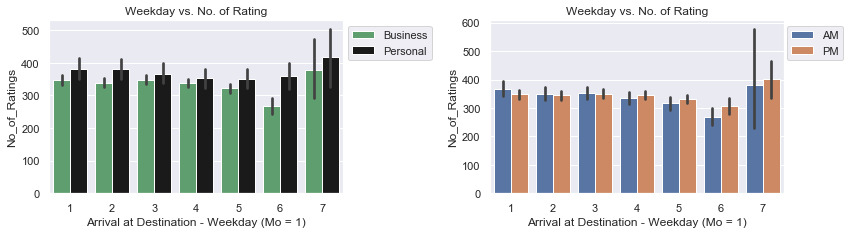

In [14]:
# plots for the train data
plt.figure(figsize = (12, 6))

# plot 1
plt.subplot(2, 2, 1)
sns.set(font_scale = 1)
sns.barplot(x = 'Arrival at Destination - Weekday (Mo = 1)' , y = 'No_of_Ratings', data = new, hue = 'Personal or Business',
           palette = ["C12", "k"])
plt.title('Weekday vs. No. of Rating', {'fontsize': 12}, loc = 'center')
plt.legend(loc='upper right', bbox_to_anchor=(1.32, 1), ncol=1)
    
# plot 2
plt.subplot(2, 2, 2)
sns.set(font_scale = 1)
sns.barplot(x = 'Arrival at Destination - Weekday (Mo = 1)', y = 'No_of_Ratings', data = new, 
              hue = 'Arrival at Destination - Time')
plt.title('Weekday vs. No. of Rating', {'fontsize': 12}, loc = 'center')
plt.legend(loc='upper right', bbox_to_anchor=(1.22, 1), ncol=1)

plt.tight_layout()
plt.show()

# Data Preprocessing

### Variable Selection

We are estimating $y$ = 'Time from Pickup to Arrival'.

We will use the following variables to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination.

In [15]:
new_train.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings', 'Experience'],
      dtype='object')

In [16]:
x_variables = ['Experience', 'Distance (KM)', 'Temperature', 'No_Of_Orders',
               'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)']

# Select the features (X) and the dependent vector (Y)

X = new_train[x_variables].values
test_x = new_test[x_variables].values

Y = new_train['Time from Pickup to Arrival'].values

### Missing Values

We will use the scikit learn library to take a mean of all the values of the same column and have it to replace the missing data.

In [17]:
# create an object of the SimpleImputer class to call the functions that are in that class
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# fit the imputer object to our data and imposing the model to our data.
imputer.fit(X[:, 1:], test_x[:, 1:])

# replace the missing values with the mean of the column by the method transform
X[:, 1:] = imputer.transform(X[:, 1:])
test_x[:, 1:] = imputer.transform(test_x[:, 1:])

### Encoding Categorical Data

For catergorical data, it is in the form that machines can easily understand and process like numerical values. We will encode the text data into a form that the machine will be able to process.

In [18]:
#create an instance of a class
ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [0])] , remainder = 'passthrough')

# to fit and transform the dataset to label encode and one hot encode the column.
X = np.array(ct.fit_transform(X))
test_x = np.array(ct.fit_transform(test_x))

### Splitting the train data into Training set and Test Set

In [19]:
# split our dataset into two sets, 80% train and 20% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Feature Scaling

A method used to standardize the range of independent variables or features of data.

In [20]:
# create an object of the StandardScaler class
sc = StandardScaler()

# transform all the data to a same standardized scale
X_train[:, 1:] = sc.fit_transform(X_train[:, 1:])
X_test[:, 1:] = sc.transform(X_test[:, 1:])
test_x[:, 1:] = sc.transform(test_x[:, 1:])

## Model Prediction

### Multiple Linear Regression 

A model give by $y$ = $b_{0}$ + $b_{1}x$ + $b_{2}x_{2}$ + $b_{3}x_{3}$ + ... + $b_{n}x_{n}$ 

In [21]:
# perform a multiple linear regression model

# train the regression model
lin_reg = LinearRegression()
lin_reg = lin_reg.fit(X_train, Y_train)

# prediction on train data
Y_lin = lin_reg.predict(X_test)

# prediction on train data
lin_pred = lin_reg.predict(test_x)

### Decision Tree Regression

It uses a flow chart like tree structure to predict the output on the basis of input or situation described by a set of properties

In [22]:
# perform a decision tree regression

a, b = X_train, Y_train

# train the model with train data
decision = DecisionTreeRegressor(random_state=42)
decision = decision.fit(a, b)

# prediction on train data
Y_decision = decision.predict(X_test)

# prediction on test data
decision_pred = decision.predict(test_x)

### Random Forest

It is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [23]:
# perform a decision tree regression
import warnings

# ignore warning
warnings.filterwarnings("ignore")

# train the model with train data
random_forest = RandomForestRegressor(random_state = 42)
random_forest = random_forest.fit(X_train, Y_train)

# prediction on train data
Y_random = random_forest.predict(X_test)

# prediction on test data
random_pred = random_forest.predict(test_x)

## Model Analysis

### Linear Regression Plots

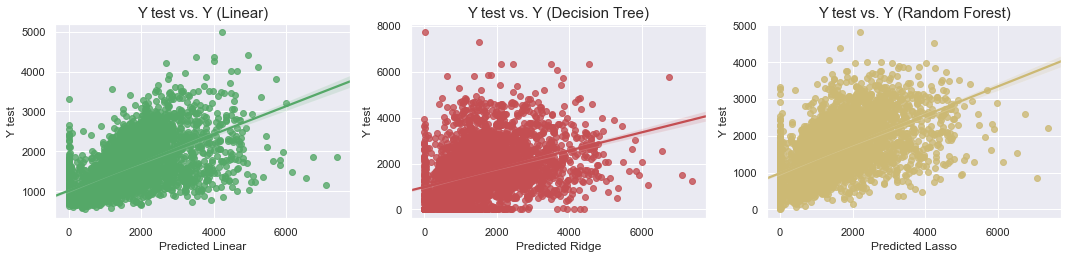

In [24]:
# regplots
plt.figure(figsize = (15, 10))
plt.subplot(3, 3, 1)
sns.regplot(Y_test,Y_lin, color='g')
plt.ylabel('Y test')
plt.xlabel('Predicted Linear')
plt.title('Y test vs. Y (Linear)', {'fontsize': 15}, loc = 'center')

plt.subplot(3, 3, 2)
sns.regplot(Y_test, Y_decision, color='r')
plt.ylabel('Y test')
plt.xlabel('Predicted Ridge')
plt.title('Y test vs. Y (Decision Tree)', {'fontsize': 15}, loc = 'center')

plt.subplot(3, 3, 3)
sns.regplot(Y_test, Y_random, color='y')
plt.ylabel('Y test')
plt.xlabel('Predicted Lasso')
plt.title('Y test vs. Y (Random Forest)', {'fontsize': 15}, loc = 'center')

plt.tight_layout()
plt.show()

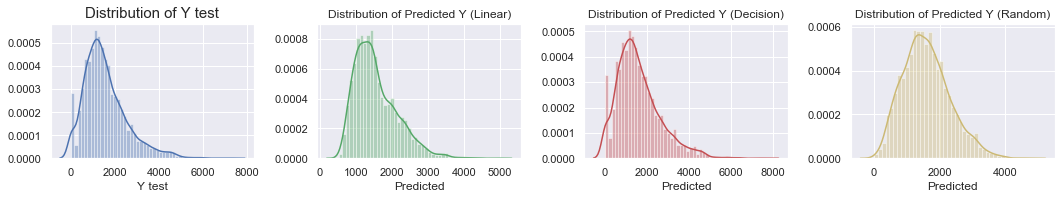

In [25]:
# train data Actual vs. Predicted
train_pred = pd.DataFrame({'Actual': Y_test, 'Predicted (Linear)': Y_lin, 'Predicted (Random)': Y_random,
                           'Predicted (Decision)': Y_decision})

plt.figure(figsize = (15, 10))

# distplots
plt.subplot(4, 4, 1)
sns.distplot(train_pred[['Actual']])
plt.xlabel('Y test')
plt.title('Distribution of Y test', {'fontsize': 15}, loc = 'center')

plt.subplot(4, 4, 2)
sns.distplot(train_pred[['Predicted (Linear)']], color='g')
plt.xlabel('Predicted')
plt.title('Distribution of Predicted Y (Linear)', {'fontsize': 12}, loc = 'center')

plt.subplot(4, 4, 3)
sns.distplot(train_pred[['Predicted (Decision)']], color='r')
plt.xlabel('Predicted')
plt.title('Distribution of Predicted Y (Decision)', {'fontsize': 12}, loc = 'center')

plt.subplot(4, 4, 4)
sns.distplot(train_pred[['Predicted (Random)']], color='y')
plt.xlabel('Predicted')
plt.title('Distribution of Predicted Y (Random)', {'fontsize': 12}, loc = 'center')

plt.tight_layout()
plt.show()

In [26]:
# test dataframe Predicted
test_pred = pd.DataFrame({'Predicted (Linear)': lin_pred, 'Predicted (Decision)': decision_pred,
                          'Predicted (Random)': random_pred})

test_pred.round(2).head()

,Predicted (Linear),Predicted (Decision),Predicted (Random)
0,1447.27,2157.0,1838.1
1,2568.42,2165.0,2563.5
2,1541.87,2157.0,1975.1
3,2166.96,4652.0,3394.8
4,2172.57,2211.0,2011.6


## Metrics

### Coefficient of Determination $R^2$ 

Represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model

In [27]:
# train data r^2
Y_lin_r2 = r2_score(Y_test, Y_lin)
Y_dec_r2 = r2_score(Y_test, Y_decision)
Y_rand_r2 = r2_score(Y_test, Y_random)

# dataframe for r^2
dict_r2 = {'R squared': [Y_lin_r2, Y_dec_r2, Y_rand_r2]}

r2 = pd.DataFrame(dict_r2, index = ['Linear', 'Decision Tree', 'Random Forest']).round(2)

### Mean Square Error

This is the average squared difference between the estimated values and the actual value.

In [28]:
# train data mse and rmse
dict_mse = {'RMSE': [mean_squared_error(Y_test, Y_lin) ** 0.5,
                     mean_squared_error(Y_test, Y_decision) ** 0.5,
                     mean_squared_error(Y_test, Y_random) ** 0.5],
            'MSE': [mean_squared_error(Y_test, Y_lin),
                    mean_squared_error(Y_test, Y_decision),
                    mean_squared_error(Y_test, Y_random)]}

mse = pd.DataFrame(dict_mse, index = ['Linear', 'Decision Tree', 'Random Forest']).round(2)

In [29]:
# metrics
metric = r2.join(mse)
metric

,R squared,RMSE,MSE
Linear,0.35,797.23,635577.05
Decision Tree,-0.31,1127.71,1271721.76
Random Forest,0.26,849.18,721113.26


# Best Model

The multiple linear regression model is the most acceptable model. It has a relatively higher $R^{2}$ and lower MSE compared to the decision tree and random forest models.

## Save Prediction Results

In [30]:
# predictions
linear_csv = pd.DataFrame({'Order No': test['Order No'] ,'Delivery Time (Seconds)': lin_pred.astype('int64')})

# predictions
decision_csv = pd.DataFrame({'Order No': test['Order No'] ,'Delivery Time (Seconds)': decision_pred.astype('int64')})

# predictions
random_csv = pd.DataFrame({'Order No': test['Order No'] , 'Delivery Time (Seconds)': random_pred.astype('int64')})

In [31]:
linear_csv.head(3)

,Order No,Delivery Time (Seconds)
0,Order_No_19248,1447
1,Order_No_12736,2568
2,Order_No_768,1541


In [32]:
# save predictions to the csv
a = linear_csv.copy()

a.to_csv('Submission.csv', index = False)

## Save the Model

In [33]:
# save the model to disk
model = lin_reg
file = 'final_model.pkl'
pickle.dump(model, open(file, 'wb'))